In [1]:
import splitfolders
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np 
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dropout, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.regularizers import l2

# DATA - GETTING AND PREPROCESSING

In [2]:
input_directory = "original_dataset"
output_directory = "datasets"

if not os.path.exists(output_directory):
    splitfolders.ratio(input_directory, 
                       output=output_directory,
                       ratio=(0.85, 0.1,0.05)) 

In [3]:
def get_image_generator (preprocessing_function, horizontal_flip, vertical_flip, rotation_range, zoom_range, width_shift_range,height_shift_range,shear_range, featurewise_std_normalization,brightness_range, rescale):
    
    image_generator = ImageDataGenerator(preprocessing_function=preprocessing_function,
                                         horizontal_flip=horizontal_flip,
                                         vertical_flip= vertical_flip,
                                         rotation_range=rotation_range,
                                         zoom_range=zoom_range,
                                         width_shift_range=width_shift_range,
                                         height_shift_range=height_shift_range,
                                         shear_range=shear_range,
                                         featurewise_std_normalization=featurewise_std_normalization,
                                         brightness_range=brightness_range,
                                         rescale = rescale)
    
    return image_generator

In [4]:
train_image_generator = get_image_generator(preprocessing_function=preprocess_input,
                                            horizontal_flip=True,
                                            vertical_flip=False,
                                            rotation_range=10,
                                            zoom_range=0.15,
                                            width_shift_range=0.1,
                                            height_shift_range=0.1,
                                            shear_range=0.15,
                                            featurewise_std_normalization=False,
                                            brightness_range=[0.9, 1.1],
                                            rescale = None)

val_image_generator = get_image_generator(preprocessing_function=preprocess_input,
                                          horizontal_flip=False,
                                          vertical_flip=False,
                                          rotation_range=0,
                                          zoom_range=0.0,
                                          width_shift_range=0.0,
                                          height_shift_range=0.0,
                                          shear_range=0.0,
                                          featurewise_std_normalization=False,
                                          brightness_range=None,
                                          rescale = None)

test_image_generator = get_image_generator(preprocessing_function=preprocess_input,
                                           horizontal_flip=False,
                                           vertical_flip=False,
                                           rotation_range=0,
                                           zoom_range=0.0,
                                           width_shift_range=0.0,
                                           height_shift_range=0.0,
                                           shear_range=0.0,
                                           featurewise_std_normalization=False,
                                           brightness_range=None,
                                           rescale = None)

In [5]:
def get_data_set(directory, image_generator, target_size, batch_size=32): 

    data_set = image_generator.flow_from_directory(directory=directory, 
                                                   target_size=target_size,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   class_mode='categorical')

    
    return data_set 

In [6]:
datasets_directory = os.path.join(os.getcwd(), output_directory)
train_dataset_directory = os.path.join(datasets_directory, "train")
val_dataset_directory = os.path.join(datasets_directory, "val")
test_dataset_directory = os.path.join(datasets_directory, "test")

In [7]:
target_size = (224,224)
batch_size = 32

train_dataset = get_data_set(train_dataset_directory,
                             train_image_generator, 
                             target_size=target_size,
                             batch_size=batch_size)

test_dataset = get_data_set(test_dataset_directory,
                            test_image_generator, 
                            target_size=target_size,
                            batch_size=batch_size)

val_dataset = get_data_set(val_dataset_directory,
                           val_image_generator, 
                           target_size=target_size,
                           batch_size=batch_size)

Found 1555 images belonging to 12 classes.
Found 103 images belonging to 12 classes.
Found 177 images belonging to 12 classes.


# DATA VISUALIZATION AND ANALYSIS

In [8]:
def show_images(data_batch, labels, nrows, ncols, batch_size):    

    images_batch = np.array(data_batch[0])
    labels_batch = np.array(data_batch[1] )
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(20,10))
    axes = axes.flatten()
    
    index = 0
    
    for ax in axes:
        if index < batch_size:
            image = images_batch[index]
            image=((image/1/255.)+1)/2
            ax.imshow(image)
            title = labels[np.argmax(labels_batch[index])]
            ax.set_title(title)
            plt.tight_layout()
            ax.set_axis_off()
            index += 1
        else: 
            break  

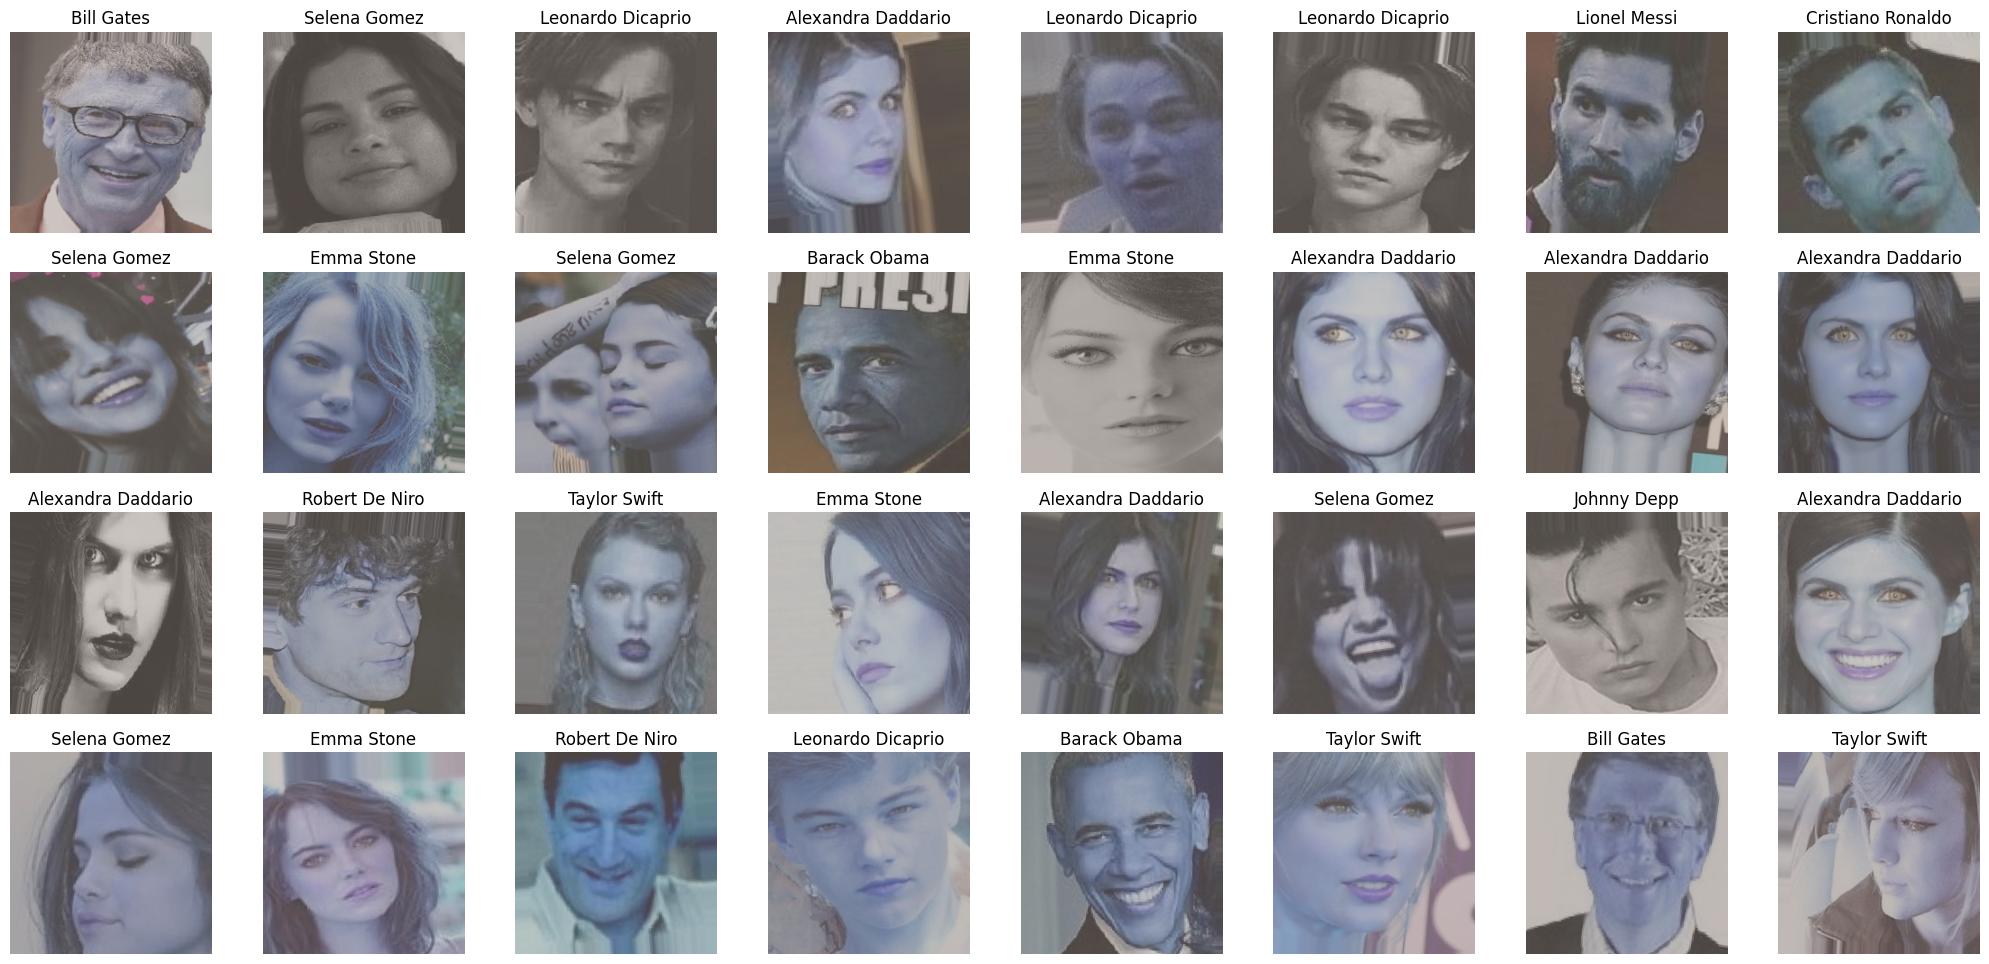

In [9]:
images_batch = next(train_dataset)
labels = {value : key.split("_")[1].title() for key, value in train_dataset.class_indices.items()}
nrows = 4
ncols=8

show_images(images_batch, labels, nrows, ncols, batch_size)

In [10]:
def get_number_of_elements_in_classes_as_df (dataset, labels):
    classes_size = Counter(dataset.classes)
    classes_labels_and_size_dict = {labels[key] : classes_size[key] for key in classes_size}
    classes_labels_and_size_df = pd.DataFrame(index = classes_labels_and_size_dict.keys(), 
                                              columns = ["Number_of_images"], 
                                              data = classes_labels_and_size_dict.values())
    return classes_labels_and_size_df

In [11]:
classes_labels_and_size_df = get_number_of_elements_in_classes_as_df (train_dataset, labels)

In [12]:
classes_labels_and_size_df

,Number_of_images
Alexandra Daddario,191
Bill Gates,103
Cristiano Ronaldo,83
Emma Stone,118
Johnny Depp,154
Leonardo Dicaprio,201
Lionel Messi,73
Robert De Niro,132
Selena Gomez,158
Shakira Isabel Mebarak,130


In [13]:
def plot_barplot_of_classes_and_elements(df):
    plt.figure(figsize=(20, 10))
    sns.barplot(x = df.index, y=df.columns[0], data = df)
    plt.xticks(rotation = 45)
    plt.title("Number of elements for each class")
    plt.show()

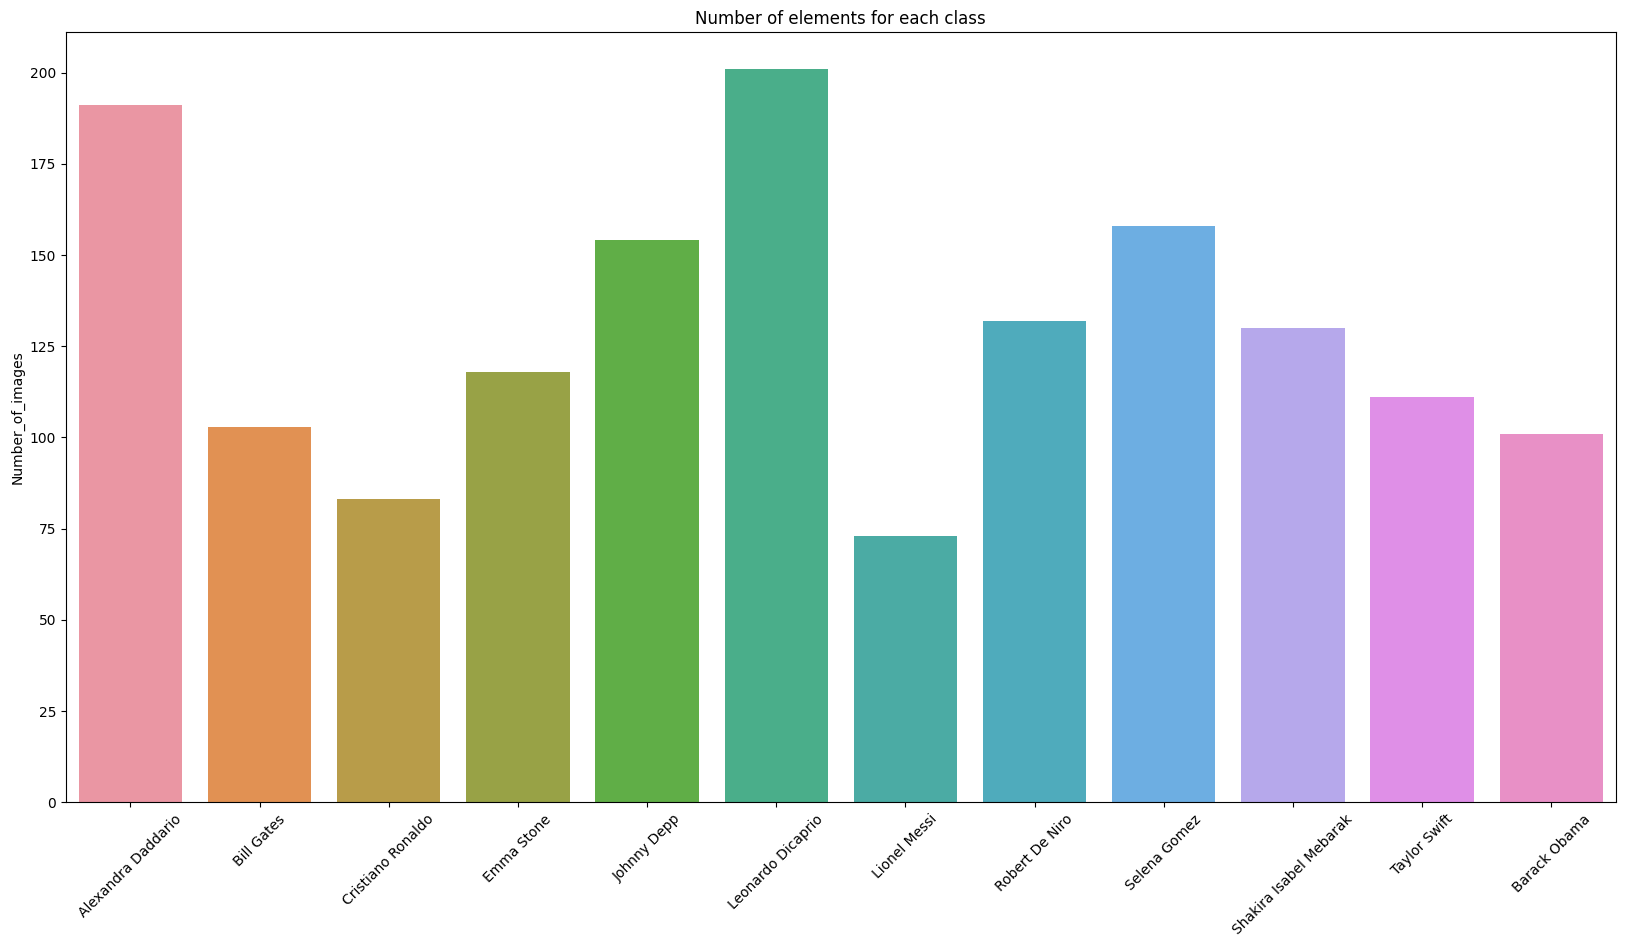

In [14]:
plot_barplot_of_classes_and_elements(classes_labels_and_size_df)

# CREATING A MODEL 

In [15]:
def get_model (pretreined_model, num_classes, loss, optimizer, metrics):
    
    pretrained_model.trainable = False 
    
    model = Sequential([
        pretrained_model,
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dropout(0.1),
        Dense(1024, activation = "elu", kernel_regularizer = l2(0.0000000001)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(num_classes, activation = "softmax")
    ])
  
    model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
    
    return model

In [16]:
input_shape = (target_size[0], target_size[1], 3)

resnet_model = ResNet50(input_shape = input_shape, include_top = True)

inputs = resnet_model.inputs
outputs = resnet_model.layers[-3].output

pretrained_model = Model(inputs = inputs, outputs = outputs)
num_classes = train_dataset.num_classes
loss = CategoricalCrossentropy()
optimizer = Adamax(learning_rate = 0.0001)
metrics = ["accuracy"]

model = get_model(pretrained_model, num_classes, loss, optimizer , metrics)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4